## PROCESS

Connect to google colab

  - Get ratio
  - Load delivery set
  - Load location data for city
  - Add functions and keys for graphhopper
  - Intialize variables for results
  - Loop through delivery set
    - For starting census tract (CT) in delivery, get some random producer from the CT
      - If no producers, use hotspot as starting
    - For ending CT in delivery, get some random consumer from CT
      - If no producers, use hotspot as ending
    - Get Graphhopper data from producer to consumer via lat/lon coords
    - Add data to final result variables
  - Print results


## Imports

In [1]:
import geopandas as gpd
# from shapely.geometry import Point
import random
import numpy as np
import pandas as pd
# import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
import os
# import time as t
# import heapq
import json
import sys
# import matplotlib.colors as mcolors
# import matplotlib.lines as mlines
import ast
import requests
from geopy.distance import geodesic
import pickle
from shapely.geometry import shape

## Load Folder

In [2]:
superspot_hotspot_ratio = 15
min_children = superspot_hotspot_ratio - 3

In [3]:
city_name = "Columbus"
mini = False

In [4]:
drive.mount('/content/gdrive/', force_remount=True)
personal_dir = "./gdrive/MyDrive/DeliverAI Data Folder/"
data_dir = f"{personal_dir}{city_name}_mini - RL Delivery Data" if mini else f"{personal_dir}{city_name} - RL Delivery Data"

# See directory content
data = os.listdir(data_dir)
print("Files in directory : ", data)

Mounted at /content/gdrive/
Files in directory :  ['Results', 'Original Location Data', 'Processed Location Data', 'Census Data', 'Hotspot Data', 'Q_boltzman.npy', 'Super Spots', 'distance_matrix.npy', 'time_matrix.npy', 'Q_epsilon.npy', 'Images', 'Q Tables', 'avg_hotspot_data.json']


## Load Data

### Delivery Class

In [5]:
class Delivery:
  id = 0
  def __init__(self, start_node, end_node, start_time, percent):
    self.id = Delivery.id
    Delivery.id += 1
    self.start_node = start_node
    self.start_node_super = tract_super_dict[self.start_node]
    self.end_node = end_node
    self.end_node_super = tract_super_dict[self.end_node]
    self.current_node = start_node
    self.time_till_next_node = 0
    self.start_time = start_time
    self.end_time = None
    self.time_limit =  None
    self.in_transition = False
    self.is_primary = True
    self.next_node = None
    self.sharing_node = None
    self.completed = False
    self.successful = False
    self.num_car_changes = 2 #For initial change from PDC to CDV and for the final change to CDV to PDC
    self.sharing_with = None
    self.path = [self.start_node]
    self.distance_traveled = 0
    self.percent_max_dist = percent
    self.step = self.set_step(percent)


    ###DEBUG VARIABLES
    self.did_share = False
    self.shared_with_final = None
    self.shared_with_when = None

  # OLD METHOD
  # def set_time_limit(self):
  #   self.time_limit = max(full_time_matrix[self.start_node][self.end_node], 900)  # Give it time limit of 15 minutes or distance needed to travel depending on which is bigger.
  def set_time_limit(self):
    global INTERVALS

    path_time = full_time_matrix[self.start_node][self.end_node] if self.step == 4 else estimate_time_matrix[self.start_node][self.end_node]

    intervals = INTERVALS
    for interval in intervals:
      if path_time*1.5 <= interval:
        self.time_limit = interval
        break


  def state_4_condition(self, percent):
    # Are census tracts in different groups?
    different_groups = self.start_node_super != self.end_node_super

    # Are census tracts bordering?
    polygon1 = shape(census_df[census_df['GEOID'] == index_to_tract[self.start_node]].iloc[0]['geometry'])
    polygon2 = shape(census_df[census_df['GEOID'] == index_to_tract[self.end_node]].iloc[0]['geometry'])

    bordering = polygon1.touches(polygon2)

    # Are the hotspots close enough for direct delivery?
    max_distance = max(estimate_dist_matrix.argmax(), full_dist_matrix.argmax())

    close_proximity = full_dist_matrix[self.start_node, self.end_node] / max_distance <=  percent / 100


    # Must be in different groups, if bordering or close enough (these conditions technically overlap), return true else false
    return different_groups and (bordering or close_proximity)

  def set_step(self, percent):
    if self.state_4_condition(percent):
      step_val = 4
    elif self.start_node_super == self.end_node_super:
      step_val = 3
    elif self.start_node_super != self.end_node_super and self.start_node_super == self.start_node:
      step_val = 2
    else:
      step_val = 1

    return step_val

  def reset(self, percent=-1):
    percent = self.percent_max_dist if percent == -1 else percent

    self.current_node = self.start_node
    self.time_till_next_node = 0
    self.end_time = None
    self.set_time_limit()
    self.in_transition = False
    self.is_primary = True
    self.next_node = None
    self.sharing_node = None
    self.completed = False
    self.successful = False
    self.num_car_changes = 2 #For initial change from PDC to CDV and for the final change to CDV to PDC
    self.sharing_with = None
    self.path = [self.start_node]
    self.distance_traveled = 0
    self.step = self.set_step(percent)


    ###DEBUG VARIABLES
    self.did_share = False
    self.shared_with_final = None
    self.shared_with_when = None


  def __lt__(self, other):
    if self.start_time != other.start_time:
      return self.start_time < other.start_time
    elif len(self.path) != len(other.path):
      return len(self.path) < len(other.path)
    else:
      return self.id < other.id

  def __str__(self):
    return f"Delivery {self.id}\n" \
           f"Start Time: \t {self.start_time}\n" \
           f"Start Hotspot: \t {self.start_node}\n" \
           f"End Hotspot: \t {self.end_node}\n" \
           f"In Transition: \t {self.in_transition}\n" \
           f"Time limit: \t {self.time_limit}\n" \
           f"Time left: \t {self.time_till_next_node}\n" \
           f"Current Hotspot: {self.current_node}\n" \
           f"Next Hotspot: \t {self.next_node}\n" \
           f"Step: \t {self.step}\n" \
           f"Sharing With: \t {self.sharing_with.id if self.sharing_with is not None else None} \n" \
           f"Shared With Final: \t {self.shared_with_final} \n" \
           f"Shared With When: \t {self.shared_with_when} \n" \
           f"Path: \t \t {self.path}\n" \
           f"Completed: \t {self.completed}\n"


### Helper Functions for Loading Deliveries

In [6]:
def gen_deliveries_id(distance_based, load, hours, percent_max_dist):
  id_str = ""

  # distance_based:
  #  - Random: 0
  #  - Further: 1
  #  - Closer: 2
  #  - One_Cluster: 3
  match distance_based:
    case "Further":
      id_str += "1"
    case "Closer":
      id_str += "2"
    case "One_Cluster":
      id_str += "3"
    case _:
      id_str += "0"

  # Adds a buffer of zeroes plus the load (4 characters total)
  load_str = str(load)
  id_str += "-" + "0" * (4 - len(load_str)) + load_str

  hours_str = str(hours)
  id_str += "-" + "0" * (3 - len(hours_str)) + hours_str

  percent_max_dist_str = str(percent_max_dist)
  id_str += "-" + "0" * (3 - len(percent_max_dist_str)) + percent_max_dist_str

  return id_str


def load_deliveries(distance_based="random", load=5, percent_max_dist=70, hours=1, graphing=False):
  deliveries_dir = data_dir + f"/Hotspot Data/Data-{min_children}-{superspot_hotspot_ratio}/Deliveries"

  if graphing:
    deliveries_dir += "/Graphing"

  deliveries_id = gen_deliveries_id(distance_based=distance_based, load=load, hours=hours, percent_max_dist=percent_max_dist)

  print("Loading from", deliveries_dir + f"/{deliveries_id}")
  with open(deliveries_dir + f"/{deliveries_id}", 'rb') as file:
    deliveries = pickle.load(file)

  return deliveries

### Load Deliveries

In [7]:
distance_based="random"
load = 300  # Modify as necessary
hours=1
percent_max_dist=100

# Get ID
deliveries_id = gen_deliveries_id(distance_based=distance_based, load=load, hours=hours, percent_max_dist=percent_max_dist)

# Get Delivery set
deliveries = load_deliveries(distance_based=distance_based, load=load, hours=hours, percent_max_dist=percent_max_dist)

Loading from ./gdrive/MyDrive/DeliverAI Data Folder/Columbus - RL Delivery Data/Hotspot Data/Data-12-15/Deliveries/0-0300-001-100


### Get Location Data for City

In [8]:
hotspot_data = gpd.read_file(data_dir + "/Hotspot Data/hotspot_data.geojson")

# Loading Tract to Index dict
with open(data_dir + "/Hotspot Data/map_geoid_index.json", 'r') as f:
    tract_to_index = json.load(f)
index_to_tract = {v: k for k, v in tract_to_index.items()}


with open(data_dir + "/Census Data/census_tract_wise_locations.json", 'r') as f:
  location_data = json.load(f)

## GraphHopper Setup

In [9]:
keys = [
  '7bcca18a-19fc-4463-b9dc-6547247167de'
]

key_ind = len(keys)-1  # Index in the list that determines which key is being used. Starts from last and works its way up because I feel cool when I do it that way

URL = "https://graphhopper.com/api/1/matrix"  # GraphHopper matrix API url
req_lim = 80  # Limit on number of requests in one go

# Generates GraphHopper query using provided params
def gh_query(from_point, to_point, keys: list):
  global key_ind

  # Do-while loop in python, runs query before checking
  while True:
    # Query to provide the key
    query = { "key": keys[key_ind] }

    # Payload to send rest of data
    payload = {
        "vehicle": "car",
        "from_points": from_point,
        "to_points": to_point,
        "out_arrays": ["distances","times"],
        "fail_fast": "true",
    }

    headers = {"Content-Type": "application/json"}

    # Get response using POST
    response = requests.post(URL, json=payload, headers=headers, params=query)
    data = response.json()  # Store data as json

    # If there is a message, then something went wrong.
    if 'message' not in data.keys():
      return data  # No message so return data
    else:  # Assume message says key ran out
      if key_ind > 0:  # Make sure we don't exit bounds of list
        key_ind -= 1
      else:  # Otherwise we have run out of keys
        if 'Minutely API limit heavily violated' not in data['message']:
          print(data['message'])
        key_ind = len(keys)-1

  return None  # Function shouldn't reach this but it's here just in case since the only other return is in an if-statement

## Get Direct Delivery Coords

In [10]:
# buildQuery(state_name, city_name, "amenity", "restaurant"),
# buildQuery(state_name, city_name, "amenity", "cafe"),
# buildQuery(state_name, city_name, "building", "apartments"),
# buildQuery(state_name, city_name, "building", "residential"),
# buildQuery(state_name, city_name, "amenity", "fast_food"),
# buildQuery(state_name, city_name, "amenity", "food_court"),
# buildQuery(state_name, city_name, "building", "college"),
# buildQuery(state_name, city_name, "building", "university"),
# buildQuery(state_name, city_name, "building", "dormitory"),
# buildQuery(state_name, city_name, "building", "hospital"),
# buildQuery(state_name, city_name, "building", "detached"),
# buildQuery(state_name, city_name, "building", "hotel"),
# buildQuery(state_name, city_name, "building", "house"),
# buildQuery(state_name, city_name, "building", "office"),
# buildQuery(state_name, city_name, "amenity", "community_centre"),
# buildQuery(state_name, city_name, "shop", "bakery"),
# buildQuery(state_name, city_name, "shop", "supermarket")

In [12]:
pickLocations = ["supermarket","restaurant","cafe","fast_food","food_court","bakery"]
dropLocations = ["apartments","residential","college","university","dormitory","hospital","detached","hotel","house","office","community_centre"]

delivery_coord_list = []
delivery_time_limits = []

for d in tqdm(deliveries[:1000]):
  delivery_time_limits.append(d.time_limit)

  start_geoid = index_to_tract[d.start_node]
  end_geoid = index_to_tract[d.end_node]

  # Filter locations so that they producer locations are in pickLocations list and consumer locations are in dropLocations list.
  producer_locations = [l for l in location_data[start_geoid] if l['amenity'] in pickLocations or l['shop'] in pickLocations]
  consumer_locations = [l for l in location_data[end_geoid] if l['amenity'] in pickLocations or l['building'] in pickLocations]

  # Pick producer and consumer at random
  if len(producer_locations) == 0:
    row = hotspot_data[hotspot_data['GEOID'] == start_geoid] # Starting hotspot coords
    producer = [[ row['geometry'].x.values[0], row['geometry'].y.values[0] ]]
  else:
    coord_data = random.choice(producer_locations)
    producer = [[ float(coord_data['lon']), float(coord_data['lat']) ]]

  if len(consumer_locations) == 0:
    row = hotspot_data[hotspot_data['GEOID'] == end_geoid] # Ending hotspot coords
    consumer = [[ row['geometry'].x.values[0], row['geometry'].y.values[0] ]]
  else:
    coord_data = random.choice(consumer_locations)
    consumer = [[ float(coord_data['lon']), float(coord_data['lat']) ]]

  delivery_coord_list.append(
    (producer, consumer)
  )

100%|██████████| 1000/1000 [00:01<00:00, 928.55it/s]


## Plot Direct Deliveries

### Load Map Data

In [115]:
census_dir = data_dir + "/Census Data/census_tract_data.geojson"
census_df = gpd.read_file(census_dir, crs='EPSG:4326')

/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option CRS
  return ogr_read(


### Create Map

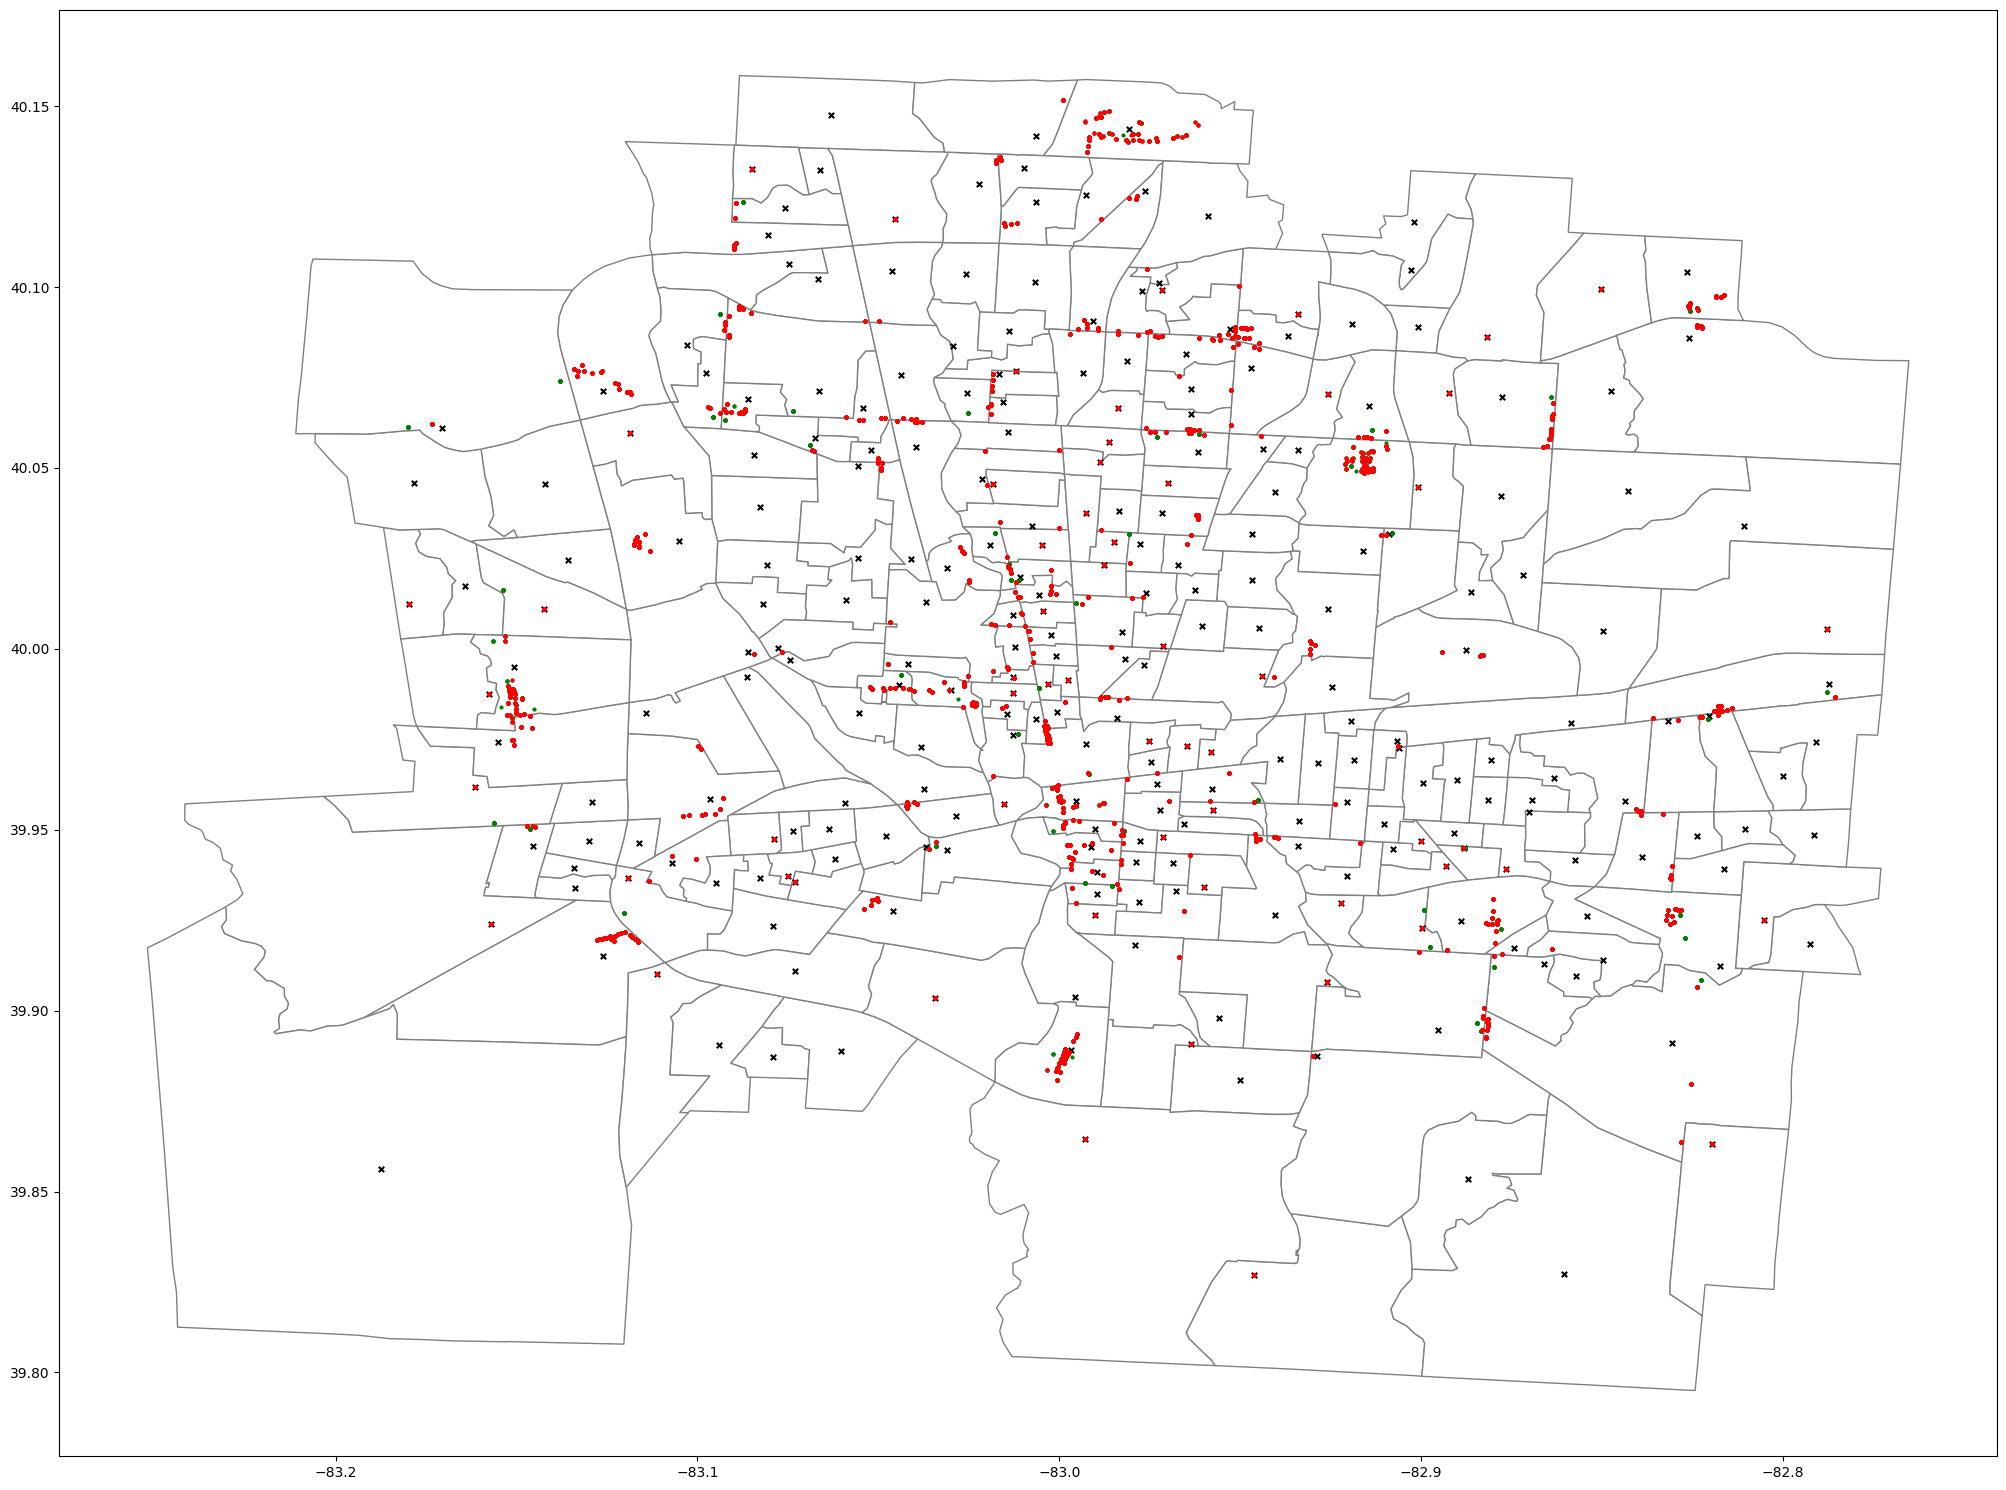

In [116]:
tract = gpd.GeoSeries(census_df.loc[:].geometry)
base = tract.plot(color="white", edgecolor="gray", figsize=(25, 25))
hotspot_data.plot(ax = base, marker='x', color='black', markersize=15, figsize=(25, 25))


start_latitudes = [point[0][0][1] for point in delivery_coord_list]
start_longitudes = [point[0][0][0] for point in delivery_coord_list]
end_latitudes = [point[1][0][1] for point in delivery_coord_list]
end_longitudes = [point[1][0][0] for point in delivery_coord_list]

gpd.GeoSeries(gpd.points_from_xy(start_longitudes, start_latitudes)).plot(ax=base, color='green', marker='o', markersize=4)
gpd.GeoSeries(gpd.points_from_xy(end_longitudes, end_latitudes)).plot(ax=base, color='red', marker='o', markersize=4)

# for i in range(len(start_latitudes)):
#     plt.arrow(start_longitudes[i], start_latitudes[i],
#               end_longitudes[i] - start_longitudes[i], end_latitudes[i] - start_latitudes[i],
#               head_width=0.005, head_length=0.01, fc='blue', ec='blue',
#               length_includes_head=True, alpha=0.5)

plt.show()

## Get Data for Direct Deliveries

In [22]:
delivery_start = [d[0][0] for d in delivery_coord_list]
delivery_end = [d[1][0] for d in delivery_coord_list]

delivery_start_chunked = []
delivery_end_chunked = []


st = 0
while st < len(delivery_start):
  ed = min(st + req_lim, len(delivery_start))

  delivery_start_chunked.append(delivery_start[st:ed])
  delivery_end_chunked.append(delivery_end[st:ed])

  st = ed

In [25]:
len(delivery_start_chunked[-1])

40

In [31]:
INTERVALS = [900, 1200, 1500, 1800, 2700, 3600, 5400, 7200, 10800, 14400]
num_deliveries = len(delivery_time_limits)

distances = []
distances_all = []
distances_tagged = []
times = []
times_all = []

successful = 0
for j in tqdm(range(len(delivery_start_chunked))):
  data = gh_query(delivery_start_chunked[j], delivery_end_chunked[j], keys)

  dsts = data['distances'][0]
  tms = data['times'][0]

  for k in range(min(req_lim, len(delivery_start_chunked[j]))):
    i = j*req_lim + k

    dst = dsts[k]
    tm = tms[k]

    is_d_successful = delivery_time_limits[i] >= tm
    if is_d_successful:
      successful += 1

      distances.append(dst)
      times.append(tm)

    distances_all.append(dst)
    times_all.append(tm)

    distances_tagged.append(
      (dst, False, is_d_successful)
    )
success_rate = successful / num_deliveries

baseline3 = {
  "shares": 0,
  'success_rate': success_rate,
  'success_rate_grouped': None,  # Implement later?
  'description': "Direct delivery between locations",
  'sharing': False,
  'distances': distances,
  'distances_all': distances_all,
  'distances_tagged': distances_tagged,
  'total_distance': sum(distances)/1000,
  'total_distance_all': sum(distances_all)/1000,
  'mean_distance': (sum(distances)/1000)/successful,
  'median_distance': np.median(distances)/1000,
  'times': times,
  'times_all': times_all,
  'mean_time': round( sum(times)/successful, 2),
  'median_time': np.median(times),
  'wait': 0,
  'hops': 1,
  'CDV': num_deliveries,
  'PDV': 0,
  'request_handler_performance': None
}


try:
  os.mkdir(data_dir + f"/Results/")
except:
  print(data_dir + f"/Results/" + " Already Exists")

try:
  os.mkdir(data_dir + f"/Results/Data-{min_children}-{superspot_hotspot_ratio}/")
except:
  print(data_dir + f"/Results/Data-{min_children}-{superspot_hotspot_ratio}/" + " Already Exists")

class NumpyArrayEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    # Check if obj is a NumPy integer and convert to Python int
    if isinstance(obj, (np.int64, np.int32, np.int16, np.int8)):
        return int(obj)
    return json.JSONEncoder.default(self, obj)

with open(f'{data_dir}/Results/Data-{min_children}-{superspot_hotspot_ratio}/baseline3_{deliveries_id}_{min_children}_{superspot_hotspot_ratio}.json', 'w') as f:
    json.dump(baseline3, f, cls=NumpyArrayEncoder)

100%|██████████| 13/13 [06:17<00:00, 29.00s/it]


./gdrive/MyDrive/DeliverAI Data Folder/Columbus - RL Delivery Data/Results/ Already Exists
./gdrive/MyDrive/DeliverAI Data Folder/Columbus - RL Delivery Data/Results/Data-12-15/ Already Exists


In [ ]:
# Print baseline3 results
for k, v in baseline3.items():
  print(k, v)

In [248]:
# Print failed deliveries
failed_delivs = [(i, d[0]) for i, d in enumerate(baseline3['distances_tagged']) if not d[2]]
print(failed_delivs)

print()
# Compare time to time limit for failed deliveries
failed_idx = [d[0] for d in failed_delivs]
for f in failed_idx:
  print(times_all[f], delivery_time_limits[f])

[(39, 13710), (53, 19397), (69, 22152), (92, 23776), (99, 24224)]

1019 900
1052 900
1422 900
1324 1200
1551 1500
